# Анализ тарифов на небольшой выборке клиентов

У нас есть компания «Мегалайн», которая предлагает клиентам два тарифных плана: **«Смарт»** и **«Ультра»**. Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. У нас есть **данные 500 пользователей** «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

**Цель исследования** - проанализировать поведение клиентов и выбрать, какой тариф лучше.

**Описание тарифов**

1) Тариф «Смарт»
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
    * o	минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей
    
2) Тариф «Ультра»
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей

Примечание:
* «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
* Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.


## Изучение данных из файла

Откроем файлы с данными и изучим общую информацию.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [2]:
data_users = pd.read_csv('/datasets/users.csv')
display(data_users.head())
data_users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В таблице `data_users` есть пропущенные значения в столбце `churn_date` (дата прекращения пользования тарифом). Посчитаем долю пропущенных значений.

In [3]:
data_users.isna().mean()

user_id       0.000
age           0.000
churn_date    0.924
city          0.000
first_name    0.000
last_name     0.000
reg_date      0.000
tariff        0.000
dtype: float64

Доля пропущенных значений в столбце `churn_date` очень велика (0.924), но в условии сказано, что если значение пропущено, то тариф ещё действовал на момент выгрузки данных. Поэтому оставим пропуски.

In [4]:
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
display(data_tariffs.head())
data_tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [5]:
data_messages = pd.read_csv('/datasets/messages.csv')
display(data_messages.head())
data_messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [6]:
data_internet = pd.read_csv('/datasets/internet.csv')
display(data_internet.head())
data_internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [7]:
data_calls = pd.read_csv('/datasets/calls.csv')
display(data_calls.head())
data_calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


**Вывод**: открыли все файлы с данными и изучили информацию, указанную там. Увидели, в каких таблицах есть пропущенные значения и где необходимо поменять тип данных.

## Предобработка данных

Приведем данные к нужным типам.

In [8]:
data_messages['id'] = data_messages['id'].astype('int64')
data_internet['id'] = data_internet['id'].astype('int64')
data_calls['id'] = data_calls['id'].astype('int64')

Заменим тип данных столбца `churn_date` на `datetime`, так как в нем указаны даты, а сейчас он имеет тип float64.

In [9]:
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d')
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    object        
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


Также в условии сказано, что «Мегалайн» всегда округляет секунды до минут. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Поэтому округлим значения в столбце duration data_calls. И поменяем тип данных с float на int.

In [10]:
data_calls.head()

,id,call_date,duration,user_id
0,10000,2018-07-25,0.00,1000
1,10001,2018-08-17,0.00,1000
2,10002,2018-06-11,2.85,1000
3,10003,2018-09-21,13.80,1000
4,10004,2018-12-15,5.18,1000


In [11]:
data_calls['duration'] = np.ceil(data_calls['duration'])
data_calls['duration'] = data_calls['duration'].astype('int')
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         202607 non-null  int64 
 1   call_date  202607 non-null  object
 2   duration   202607 non-null  int64 
 3   user_id    202607 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 6.2+ MB


**Вывод**: провели предобработку данных. Привели данные к нужным типам. Округлили значения для звонков.

## Расчеты

**Возьмем таблицу data_calls и посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам.**

Для этого сначала из столбца call_date выделим месяц и дальше сгруппируем данные по нему.

In [12]:
data_calls.head()

,id,call_date,duration,user_id
0,10000,2018-07-25,0,1000
1,10001,2018-08-17,0,1000
2,10002,2018-06-11,3,1000
3,10003,2018-09-21,14,1000
4,10004,2018-12-15,6,1000


In [13]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
data_calls['month'] = pd.DatetimeIndex(data_calls['call_date']).month
data_calls.head()

,id,call_date,duration,user_id,month
0,10000,2018-07-25,0,1000,7
1,10001,2018-08-17,0,1000,8
2,10002,2018-06-11,3,1000,6
3,10003,2018-09-21,14,1000,9
4,10004,2018-12-15,6,1000,12


In [14]:
calls_count = data_calls.groupby(['user_id', 'month'])['duration'].count().reset_index() #количество звонков
calls_count = calls_count.rename(columns={'duration': 'count_calls'})
display(calls_count.head())

calls_sum = data_calls.groupby(['user_id', 'month'])['duration'].sum().reset_index() #количество израсходованных минут
calls_sum = calls_sum.rename(columns={'duration': 'calls'})
display(calls_sum.head())

calls = calls_count.merge(calls_sum, on=['user_id', 'month'], how='left')
calls.head()

,user_id,month,count_calls
0,1000,5,22
1,1000,6,43
2,1000,7,47
3,1000,8,52
4,1000,9,58


,user_id,month,calls
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466


,user_id,month,count_calls,calls
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


**Возьмем таблицу data_messages и посчитаем количество отправленных сообщений по месяцам аналогично как для data_calls.**

In [15]:
data_messages.head()

,id,message_date,user_id
0,10000,2018-06-27,1000
1,10001,2018-10-08,1000
2,10002,2018-08-04,1000
3,10003,2018-06-16,1000
4,10004,2018-12-05,1000


In [16]:
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
data_messages['month'] = pd.DatetimeIndex(data_messages['message_date']).month
data_messages.head()

,id,message_date,user_id,month
0,10000,2018-06-27,1000,6
1,10001,2018-10-08,1000,10
2,10002,2018-08-04,1000,8
3,10003,2018-06-16,1000,6
4,10004,2018-12-05,1000,12


In [17]:
messages = data_messages.groupby(['user_id', 'month'])['id'].count().reset_index() #количество сообщений
messages = messages.rename(columns={'id': 'messages'})
messages.head()

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


**Возьмем таблицу data_internet и посчитаем объем израсходованного интернет-трафика по месяцам аналогично как для data_calls.**

In [18]:
data_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,10000,112.95,2018-11-25,1000
1,1,10001,1052.81,2018-09-07,1000
2,2,10002,1197.26,2018-06-25,1000
3,3,10003,550.27,2018-08-22,1000
4,4,10004,302.56,2018-09-24,1000


In [19]:
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')
data_internet['month'] = pd.DatetimeIndex(data_internet['session_date']).month
data_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,10000,112.95,2018-11-25,1000,11
1,1,10001,1052.81,2018-09-07,1000,9
2,2,10002,1197.26,2018-06-25,1000,6
3,3,10003,550.27,2018-08-22,1000,8
4,4,10004,302.56,2018-09-24,1000,9


Получили новую таблицу sum_mb. В условии задачи указано: общая сумма за месяц округляется в бо́льшую сторону. Поэтому перевели значения в столбце mb_used из Мб в Гб и округлили их в большую сторону.

In [20]:
sum_mb = data_internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index() #объем израсходованного интернет-трафика Л
sum_mb['gb_used'] = sum_mb['mb_used'] / 1024
sum_mb['gb_used'] = np.ceil(sum_mb['gb_used'])
sum_mb.pop('mb_used')
sum_mb.head()

,user_id,month,gb_used
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0


Объединим таблицы calls и messages.

In [21]:
call_mes = calls.merge(messages, on=['user_id', 'month'], how='outer')
display(call_mes.head())
call_mes.info()

,user_id,month,count_calls,calls,messages
0,1000,5,22.0,159.0,22.0
1,1000,6,43.0,172.0,60.0
2,1000,7,47.0,340.0,75.0
3,1000,8,52.0,408.0,81.0
4,1000,9,58.0,466.0,57.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 0 to 3212
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      3213 non-null   int64  
 1   month        3213 non-null   int64  
 2   count_calls  3174 non-null   float64
 3   calls        3174 non-null   float64
 4   messages     2717 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 150.6 KB


Теперь объединим таблицы call_mes и sum_mb.

In [22]:
call_mes_int = call_mes.merge(sum_mb, on=['user_id', 'month'], how='outer')
call_mes_int.head()
call_mes_int.head(10)

,user_id,month,count_calls,calls,messages,gb_used
0,1000,5,22.0,159.0,22.0,3.0
1,1000,6,43.0,172.0,60.0,23.0
2,1000,7,47.0,340.0,75.0,14.0
3,1000,8,52.0,408.0,81.0,14.0
4,1000,9,58.0,466.0,57.0,15.0
5,1000,10,57.0,350.0,73.0,15.0
6,1000,11,43.0,338.0,58.0,15.0
7,1000,12,46.0,333.0,70.0,10.0
8,1001,11,59.0,430.0,NaN,18.0
9,1001,12,63.0,414.0,NaN,14.0


Заменим пропуски в столбце `messages` на 0.

In [23]:
call_mes_int['messages'] = call_mes_int['messages'].fillna(0)
call_mes_int['messages'].isna().sum()
call_mes_int.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      3214 non-null   int64  
 1   month        3214 non-null   int64  
 2   count_calls  3174 non-null   float64
 3   calls        3174 non-null   float64
 4   messages     3214 non-null   float64
 5   gb_used      3203 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


В столбце `gb_used` тоже есть пропуски. Заменим их.

In [24]:
call_mes_int['gb_used'].isna().sum()
call_mes_int['gb_used'].unique()
call_mes_int['gb_used'] = call_mes_int['gb_used'].fillna(0)
call_mes_int['gb_used'].isna().sum()
call_mes_int.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      3214 non-null   int64  
 1   month        3214 non-null   int64  
 2   count_calls  3174 non-null   float64
 3   calls        3174 non-null   float64
 4   messages     3214 non-null   float64
 5   gb_used      3214 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


In [25]:
call_mes_int.head()

,user_id,month,count_calls,calls,messages,gb_used
0,1000,5,22.0,159.0,22.0,3.0
1,1000,6,43.0,172.0,60.0,23.0
2,1000,7,47.0,340.0,75.0,14.0
3,1000,8,52.0,408.0,81.0,14.0
4,1000,9,58.0,466.0,57.0,15.0


Из таблицы данных о пользователе извлечем 2 столбца: название тарифа и идентификатор пользователя.

In [26]:
tariff = data_users[['user_id', 'tariff']]
tariff.head()

,user_id,tariff
0,1000,ultra
1,1001,smart
2,1002,smart
3,1003,ultra
4,1004,ultra


Объединим таблицы call_mes_int и tariff в новую таблицу data.

In [27]:
data = call_mes_int.merge(tariff, on=['user_id'])
data = data.rename(columns={'tariff': 'tariff_name'})
data.head()

,user_id,month,count_calls,calls,messages,gb_used,tariff_name
0,1000,5,22.0,159.0,22.0,3.0,ultra
1,1000,6,43.0,172.0,60.0,23.0,ultra
2,1000,7,47.0,340.0,75.0,14.0,ultra
3,1000,8,52.0,408.0,81.0,14.0,ultra
4,1000,9,58.0,466.0,57.0,15.0,ultra


In [28]:
data_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Объединим таблицы data и data_tariffs в одну.

In [29]:
data = data.merge(data_tariffs, on=['tariff_name'])
data.head()

,user_id,month,count_calls,calls,messages,gb_used,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,159.0,22.0,3.0,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,43.0,172.0,60.0,23.0,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,47.0,340.0,75.0,14.0,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,52.0,408.0,81.0,14.0,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,58.0,466.0,57.0,15.0,ultra,1000,30720,3000,1950,150,1,1


**Посчитаем для каждого пользователя помесячную выручку.**

Для этого:

* Сначала сложим количество звонков, сообщений и интернет-трафика.
* Потом из бесплатного лимита вычтим эту сумму.
* Остаток умножим на значение из тарифного плана.
* Прибавим абонентскую плату.

In [30]:
data['calls_overrun'] = data['calls'] - data['minutes_included']
data['gb_overrun'] = data['gb_used'] - data['mb_per_month_included']/1024 #перевели Мб в Гб
data['mes_overrun'] = data['messages'] - data['messages_included']
data.head()

,user_id,month,count_calls,calls,messages,gb_used,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_overrun,gb_overrun,mes_overrun
0,1000,5,22.0,159.0,22.0,3.0,ultra,1000,30720,3000,1950,150,1,1,-2841.0,-27.0,-978.0
1,1000,6,43.0,172.0,60.0,23.0,ultra,1000,30720,3000,1950,150,1,1,-2828.0,-7.0,-940.0
2,1000,7,47.0,340.0,75.0,14.0,ultra,1000,30720,3000,1950,150,1,1,-2660.0,-16.0,-925.0
3,1000,8,52.0,408.0,81.0,14.0,ultra,1000,30720,3000,1950,150,1,1,-2592.0,-16.0,-919.0
4,1000,9,58.0,466.0,57.0,15.0,ultra,1000,30720,3000,1950,150,1,1,-2534.0,-15.0,-943.0


In [31]:
data['calls_overrun'] = data['calls'] - data['minutes_included']
data['gb_overrun'] = data['gb_used'] - data['mb_per_month_included']/1024 #перевели Мб в Гб
data['mes_overrun'] = data['messages'] - data['messages_included']

def income(data):
    income_min = 0
    income_mes = 0
    income_internet = 0
    if data['calls_overrun'] > 0:
        income_min = data['calls_overrun'] * data['rub_per_minute']
    if data['mes_overrun'] > 0:
        income_mes = data['mes_overrun'] * data['rub_per_message']
    if data['gb_overrun'] > 0:
        income_internet = data['gb_overrun'] * data['rub_per_gb']
    if data['tariff_name'] == 'ultra':
        income_tariff = 1950
    if data['tariff_name'] == 'smart':
        income_tariff = 550 
    return income_min + income_mes + income_internet + income_tariff

data['income'] = data.apply(income, axis=1)
data.head()

,user_id,month,count_calls,calls,messages,gb_used,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_overrun,gb_overrun,mes_overrun,income
0,1000,5,22.0,159.0,22.0,3.0,ultra,1000,30720,3000,1950,150,1,1,-2841.0,-27.0,-978.0,1950.0
1,1000,6,43.0,172.0,60.0,23.0,ultra,1000,30720,3000,1950,150,1,1,-2828.0,-7.0,-940.0,1950.0
2,1000,7,47.0,340.0,75.0,14.0,ultra,1000,30720,3000,1950,150,1,1,-2660.0,-16.0,-925.0,1950.0
3,1000,8,52.0,408.0,81.0,14.0,ultra,1000,30720,3000,1950,150,1,1,-2592.0,-16.0,-919.0,1950.0
4,1000,9,58.0,466.0,57.0,15.0,ultra,1000,30720,3000,1950,150,1,1,-2534.0,-15.0,-943.0,1950.0


## Исследовательский анализ данных

**Опишем поведение клиентов оператора, исходя из выборки. Для этого узнаем, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы.**

Разделим нашу таблицу data на 2: 1 с тарифом ультра, 2 - смарт.

In [32]:
data_ultra = data.query('tariff_name == "ultra"')
data_smart = data.query('tariff_name == "smart"')
data_ultra.head()

,user_id,month,count_calls,calls,messages,gb_used,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_overrun,gb_overrun,mes_overrun,income
0,1000,5,22.0,159.0,22.0,3.0,ultra,1000,30720,3000,1950,150,1,1,-2841.0,-27.0,-978.0,1950.0
1,1000,6,43.0,172.0,60.0,23.0,ultra,1000,30720,3000,1950,150,1,1,-2828.0,-7.0,-940.0,1950.0
2,1000,7,47.0,340.0,75.0,14.0,ultra,1000,30720,3000,1950,150,1,1,-2660.0,-16.0,-925.0,1950.0
3,1000,8,52.0,408.0,81.0,14.0,ultra,1000,30720,3000,1950,150,1,1,-2592.0,-16.0,-919.0,1950.0
4,1000,9,58.0,466.0,57.0,15.0,ultra,1000,30720,3000,1950,150,1,1,-2534.0,-15.0,-943.0,1950.0


Посчитаем среднее количество минут, сообщений и трафика в разных тарифах и построим столбчатые диаграммы.

Начнем с расчета среднего количества минут для разных тарифов в зависимости от месяца. Построим диаграмму.

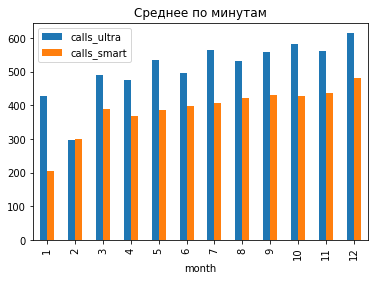

In [33]:
mean_ultra_call = data_ultra.groupby('month')['calls'].mean().reset_index()
mean_smart_call = data_smart.groupby('month')['calls'].mean().reset_index()

both_call = mean_ultra_call.merge(mean_smart_call, on='month')
both_call = both_call.rename(columns={'calls_x': 'calls_ultra', 'calls_y': 'calls_smart'})
both_call.plot(kind='bar', x='month')
plt.title('Среднее по минутам')
plt.show()

Вывод: Из графика видно, что для тарифа ультра среднее по минутам больше во всех месяцах, кроме 2. Во 2 месяце значения примерно одинаковы (около 300). Больше всего для обоих тарифов потрачено минут в последнем месяце: почти 600 для ультра и около 450 для смарта. В тарифе ультра изначально дано гораздо больше минут, чем в тарифе смарт (3000 против 500). Хотя из графика видно, что пользователи этим не пользуются (максимальное потраченное количество минут в тарифе смарт окоо 600).

Теперь посчитаем среднее количество сообщение для разных тарифов в зависимости от месяца и построим столбчатую диаграмму.

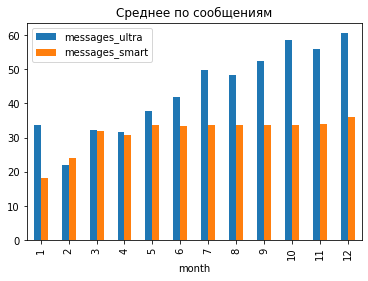

In [34]:
mean_ultra_mes = data_ultra.groupby('month')['messages'].mean().reset_index()
mean_smart_mes = data_smart.groupby('month')['messages'].mean().reset_index()

both_mes = mean_ultra_mes.merge(mean_smart_mes, on='month')
both_mes = both_mes.rename(columns={'messages_x': 'messages_ultra', 'messages_y': 'messages_smart'})
both_mes.plot(kind='bar', x='month')
plt.title('Среднее по сообщениям')
plt.show()

Вывод: Из графика видно, что для тарифа ультра средние по сообщениям больше во всех месяцах также, кроме 2. Во 2 месяце значения тарифа ультра чуть меньше, чем смарт. Больше всего для обоих тарифов отправлено сообщений в последнем месяце: почти 60 для ультра и около 30 для смарта. В тариф смарт включено всего 50 сообщений, на графике видно, что пользователи укладываются в это число. А в тариф ультра включена 1000 сообщений, но судя по графику, этим количеством никто не пользуется, максимальное значение для ультра около 60.

Посчитаем средний трафик для разных тарифов в зависимости от месяца и столбчатые диаграммы.

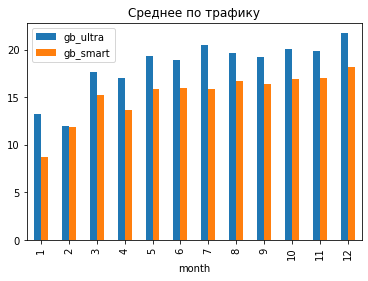

In [35]:
mean_ultra_gb = data_ultra.groupby('month')['gb_used'].mean().reset_index()
mean_smart_gb = data_smart.groupby('month')['gb_used'].mean().reset_index()

both_gb = mean_ultra_gb.merge(mean_smart_gb, on='month')
both_gb = both_gb.rename(columns={'gb_used_x': 'gb_ultra', 'gb_used_y': 'gb_smart'})
both_gb.plot(kind='bar', x='month')
plt.title('Среднее по трафику')
plt.show()

Вывод: Из графика видно, что пользователи тарифа ультра используют больше трафика, чем пользователи смарта. Это можно объяснить тем, что в их тариф включено в 2 раза больше Гб, чем в смарте (30 против 15). Пользователи тарифа смарт в основном тратят все свои 15 Гб, наименьшие значения обнаружены только в первые 2 месяца.

Посчитаем дисперсию по звонкам для разных тарифов.

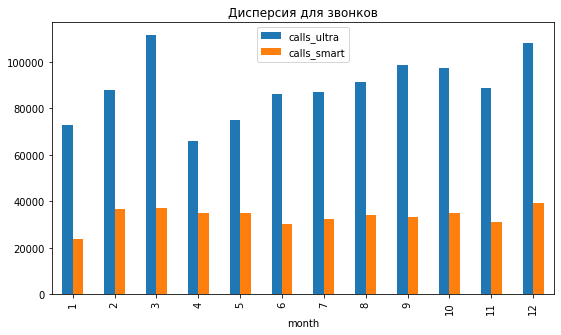

In [36]:
disp_smart_call = data[data['tariff_name'] == 'smart'].groupby('month')['calls'].agg('var').reset_index()
disp_ultra_call = data[data['tariff_name'] == 'ultra'].groupby('month')['calls'].agg('var').reset_index()

both_disp_call = disp_ultra_call.merge(disp_smart_call, on='month')
both_disp_call = both_disp_call.rename(columns={'calls_x': 'calls_ultra', 'calls_y': 'calls_smart'})
both_disp_call.plot(kind='bar', x='month', figsize=(9, 5))
plt.title('Дисперсия для звонков')
plt.show()

Вывод: Из графика видно, что дисперсия по звонкам для тарифа смарт в 2 и более раз меньше, чем для тарифа ультра.

Посчитаем дисперсию по сообщениям для разных тарифов.

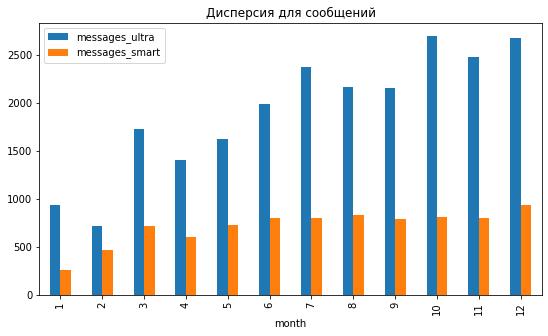

In [37]:
disp_smart_messages = data[data['tariff_name'] == 'smart'].groupby('month')['messages'].agg('var').reset_index()
disp_ultra_messages = data[data['tariff_name'] == 'ultra'].groupby('month')['messages'].agg('var').reset_index()
both_disp_messages = disp_ultra_messages.merge(disp_smart_messages, on='month')
both_disp_messages = both_disp_messages.rename(columns={'messages_x': 'messages_ultra', 'messages_y': 'messages_smart'})
both_disp_messages.plot(kind='bar', x='month', figsize=(9, 5))
plt.title('Дисперсия для сообщений')
plt.show()

Вывод: Дисперсия по сообщениям для тарифа ультра также больше. Наблюдается ее увеличение от первого месяца к последнему. Дисперсия же для тарифа смарт распределена более равномерно. Большинство значение лежит вблизи 1000.

Посчитаем дисперсию по трафику для разных тарифов.

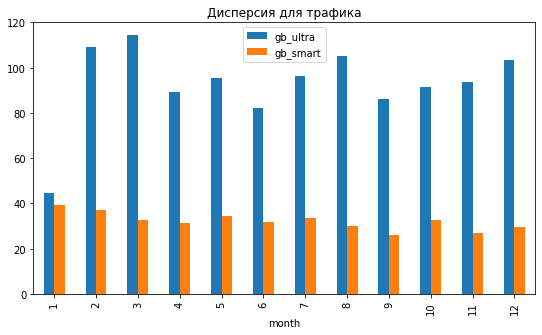

In [38]:
disp_smart_gb = data[data['tariff_name'] == 'smart'].groupby('month')['gb_used'].agg('var').reset_index()
disp_ultra_gb = data[data['tariff_name'] == 'ultra'].groupby('month')['gb_used'].agg('var').reset_index()
both_disp_gb = disp_ultra_gb.merge(disp_smart_gb, on='month')
both_disp_gb = both_disp_gb.rename(columns={'gb_used_x': 'gb_ultra', 'gb_used_y': 'gb_smart'})
both_disp_gb.plot(kind='bar', x='month', figsize=(9, 5))
plt.title('Дисперсия для трафика')
plt.show()

Вывод: Дисперсия для трафика по тарифу смарт также больше.

Посчитаем стандартное отклонение по звонкам для разных тарифов.

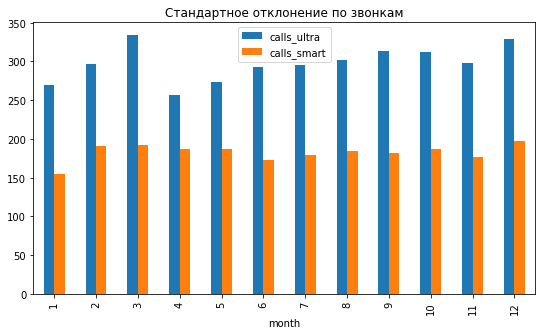

In [39]:
stand_ultra_call = data[data['tariff_name'] == 'ultra'].groupby('month')['calls'].agg('std').reset_index()
stand_smart_call = data[data['tariff_name'] == 'smart'].groupby('month')['calls'].agg('std').reset_index()

both_stand_call = stand_ultra_call.merge(stand_smart_call, on='month')
both_stand_call = both_stand_call.rename(columns={'calls_x': 'calls_ultra', 'calls_y': 'calls_smart'})
both_stand_call.plot(kind='bar', x='month', figsize=(9, 5))
plt.title('Стандартное отклонение по звонкам')
plt.show()

Посчитаем стандартное отклонение по сообщениям для разных тарифов.

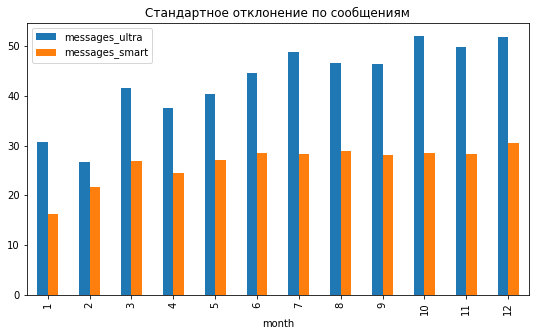

In [40]:
stand_ultra_mes = data[data['tariff_name'] == 'ultra'].groupby('month')['messages'].agg('std').reset_index()
stand_smart_mes = data[data['tariff_name'] == 'smart'].groupby('month')['messages'].agg('std').reset_index()

both_stand_mes = stand_ultra_mes.merge(stand_smart_mes, on='month')
both_stand_mes = both_stand_mes.rename(columns={'messages_x': 'messages_ultra', 'messages_y': 'messages_smart'})
both_stand_mes.plot(kind='bar', x='month', figsize=(9, 5))
plt.title('Стандартное отклонение по сообщениям')
plt.show()

Посчитаем стандартное отклонение по трафику для разных тарифов.

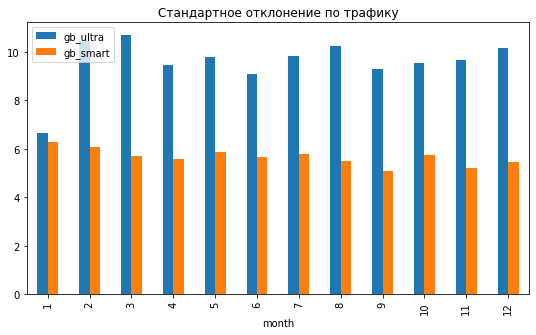

In [41]:
stand_ultra_gb = data[data['tariff_name'] == 'ultra'].groupby('month')['gb_used'].agg('std').reset_index()
stand_smart_gb = data[data['tariff_name'] == 'smart'].groupby('month')['gb_used'].agg('std').reset_index()

both_stand_gb = stand_ultra_gb.merge(stand_smart_gb, on='month')
both_stand_gb = both_stand_gb.rename(columns={'gb_used_x': 'gb_ultra', 'gb_used_y': 'gb_smart'})
both_stand_gb.plot(kind='bar', x='month', figsize=(9, 5))
plt.title('Стандартное отклонение по трафику')
plt.show()

Логично, что и для стандартного отклонения все значения по звонкам, сообщениям и трафику для тарифа смарт буду меньше, чем для тарифа ультра, т.к. стандартное отклонение - это корень из дисперсии.

**Вывод**:

Средние значения, дисперсия и стандартное отклонение для тарифа смарт меньше, чем для тарифа ультра. Это можно объяснить тем, что в пакет тарифа ультра входит гораздо большее количество звонков, смс и трафика (3000 минут разговора против 500, 1000 сообщений против 50 и 30 Гб интернет-трафика против 15).

Построим гистограммы по 3-м услугам (звонки, сообщения, интернет).

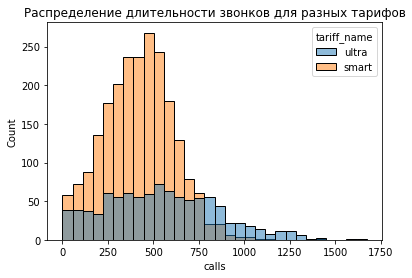

In [42]:
sns.histplot(data=data, x='calls', hue='tariff_name', bins=30)
plt.title('Распределение длительности звонков для разных тарифов')
plt.show()

У тарифа смарт лимит 500 минут. Из графика видно, что он превышен, у smart много наблюдений на минутах посередине. При этом на больших длительностях видно что ultra выходит вперед, поэтому средне ultra больше, чем smart. У тарифа ultra виден длинный хвост на гистограмме, засчет этого его среднее больше. У тарифа ультра лимит 3000 минут и все пользователи в него укладываются.

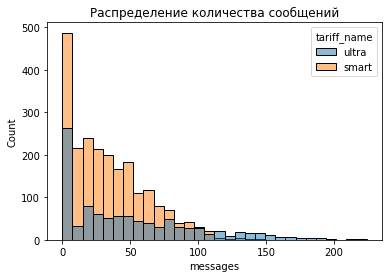

In [43]:
sns.histplot(data=data, x='messages', hue='tariff_name', bins=30)
plt.title('Распределение количества сообщений')
plt.show()

Из графика видно, что не все пользователи тарифа смарт укладываются в свой лимит (50 сообщений), но есть и такие, кто совсем не отправляет смс (пик при 0). Их около 500. Для тарифа ультра данные рапределены более равномерно, но тоже виден пик вблизи 300. У тарифа ультра лимит 1000 сообщений и все пользователи в него укладываются.

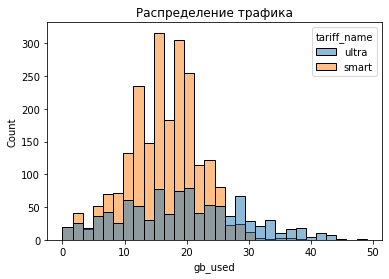

In [44]:
sns.histplot(data=data, x='gb_used', hue='tariff_name', bins=30)
plt.title('Распределение трафика')
plt.show()

У пользователей тарифа смарт лимит трафика 15 Гб. На графике наблюдается пик как раз для этого значения, но есть и еще один пик вблизи 20 Гб. Пользователи не укладываются в лимит. У тарифа ультра лимит 30 Гб, но также видно, что не все пользователи в него укладываются.

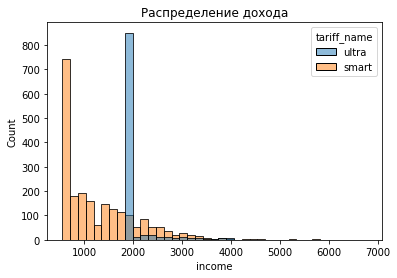

In [45]:
sns.histplot(data=data, x='income', hue='tariff_name')
plt.title('Распределение дохода')
plt.show()

**Вывод**:

В тарифе ультра есть превышение лимита по смс и звонкам. По трафику лимиты превышены для обоих тарифов. Доход тарифа ультра больше, чем у смарта. Тариф ультра оказывается выгоднее.

## Проверка гипотез

**Гипотеза №1: средние выручки пользователей тарифов «Ультра» и «Смарт» совпадают.**

У нас есть нулевая гипотеза Н_0 - средние выручки пользователей тарифов «Ультра» и «Смарт» совпадают, т.е. средние значения равны.
Н_1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается, т.е. средние значения не равны.

Проведем ttest (st.ttest_ind) и исходя из p-value решим, принять или отвергнуть нулевую гипотезу.

In [46]:
sample_1 = data.query('tariff_name == "ultra"')['income']
sample_2 = data.query('tariff_name == "smart"')['income']
 
alpha = .05 # критический уровень статистической значимости
 
results = st.ttest_ind(
    sample_1, 
    sample_2)
 
print('p-значение:', results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


Проверим это и посчитаем среднюю выручку для разных тарифов.

In [47]:
display(data.query('tariff_name == "ultra"')['income'].mean())
data.query('tariff_name == "smart"')['income'].mean()

2070.1522842639592

1289.9735307312696

Выручка тарифа ультра больше.

Я выбрала уровень статистической значимости (alpha) равным 5%, т.к. у нас небольшой размер данных. Если бы их было несколько млн, то можно было взять бы и 1%.

**Вывод**: p-value получилось меньше alpha, значит, мы отвергаем нашу нулевую гипотезу. Получается, что средние выручки пользователей тарифов ультра и смарт различается. Доход тарифа ультра больше.

**Гипотеза №2: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.**

Нулевая гипотеза Н_0 - средняя выручка пользователей из Москвы равна выручке пользователей из других регионов. Н_1 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов, т.е. они не равны.

Проведем ttest (st.ttest_ind) и исходя из p-value решим, принять или отвергнуть нулевую гипотезу.

Сначала извлечем из таблицы данных о пользователях (data_users) столбец с городамии и добавим его в нашу сводную таблицу data.

In [48]:
city = data_users[['user_id', 'city']]
data = data.merge(city, on=['user_id'])
data.head()

,user_id,month,count_calls,calls,messages,gb_used,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_overrun,gb_overrun,mes_overrun,income,city
0,1000,5,22.0,159.0,22.0,3.0,ultra,1000,30720,3000,1950,150,1,1,-2841.0,-27.0,-978.0,1950.0,Краснодар
1,1000,6,43.0,172.0,60.0,23.0,ultra,1000,30720,3000,1950,150,1,1,-2828.0,-7.0,-940.0,1950.0,Краснодар
2,1000,7,47.0,340.0,75.0,14.0,ultra,1000,30720,3000,1950,150,1,1,-2660.0,-16.0,-925.0,1950.0,Краснодар
3,1000,8,52.0,408.0,81.0,14.0,ultra,1000,30720,3000,1950,150,1,1,-2592.0,-16.0,-919.0,1950.0,Краснодар
4,1000,9,58.0,466.0,57.0,15.0,ultra,1000,30720,3000,1950,150,1,1,-2534.0,-15.0,-943.0,1950.0,Краснодар


In [49]:
sample_1 = data.query('city == "Москва"')['income']
sample_2 = data.query('city != "Москва"')['income']
 
alpha = .05 # критический уровень статистической значимости
 
results = st.ttest_ind(
    sample_1, 
    sample_2)
 
print('p-значение:', results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


Вывод: p-value получилось меньше критического уровеня статистической значимости, значит, принимаем нашу нулевую гипотезу. Получается, что средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

## Общий вывод

1) Мы посчитайте для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам
* количество отправленных сообщений по месяцам
* объем израсходованного интернет-трафика по месяцам
* помесячную выручку с каждого пользователя

2) Посчитали среднее количество, дисперсию и стандартное отклонение для количества минут, сообщений и объема интернет-трафика. Построили гистограммы по этим данным.

3) Выяснили, что данные распределены равномерно, нет аномалий или выбросов. 

4) Средние значения для звонков, смс и интернета получились меньше для тарифа смарт, чем для тарифа ультра. Объяснили это тем, что в пакет тарифа ультра входит гораздо большее количество звонков, смс и трафика. (3000 минут разговора против 500, 1000 сообщений против 50 и 30 Гб интернет-трафика против 15).

5) Построили гистограммы по 2 тарифам для звонков, сообщений, интернета и дохода. Выяснили, что для тарифа смарт превышен лимит по звонкам и смс. А по трафику есть превышение лимита у обоих тарифов. Но все-так доход больше у тарифа ультра. Поэтому оператору следует продвигать его.

6) Проверили первую гипотезу: средние выручки пользователей тарифов «Ультра» и «Смарт» совпадают. Отвергли ее. Выяснили, что средние выручки двух тарифов отличаются. Доход тарифа ультра больше.

7) Проверили вторую гипотезу: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов. Подтвердили эту гипотезу.